**K-MEANS CLUSTERING**

In [0]:
import keras as keras
from keras.models import Sequential
from keras.models import Model
from sklearn import metrics
from keras.preprocessing.image import load_img,array_to_img
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from keras.layers import Dense,Input
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

Using TensorFlow backend.


In [0]:
def infer_cluster_labels(kmeans, actual_labels):
    inferred_labels = {}
    for i in range(10):
        labels = []
        index = np.where(kmeans.labels_ == i)
        labels.append(actual_labels[index])
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))
        if np.argmax(counts) in inferred_labels:
            inferred_labels[np.argmax(counts)].append(i)
        else:
            inferred_labels[np.argmax(counts)] = [i]
    return inferred_labels  
def infer_data_labels(X_labels, cluster_labels):
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
       
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [0]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='auto')

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(
    n_clusters=10, init='k-means++',
    n_init=10,max_iter=350, 
    tol=1e-10, random_state=0,verbose = 1
)
y_pred = kmeans.fit_predict(x_train)


Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 2063387.1
start iteration
done sorting
end inner loop
Iteration 1, inertia 1996065.4
start iteration
done sorting
end inner loop
Iteration 2, inertia 1979764.5
start iteration
done sorting
end inner loop
Iteration 3, inertia 1971383.9
start iteration
done sorting
end inner loop
Iteration 4, inertia 1967549.6
start iteration
done sorting
end inner loop
Iteration 5, inertia 1965189.1
start iteration
done sorting
end inner loop
Iteration 6, inertia 1962967.1
start iteration
done sorting
end inner loop
Iteration 7, inertia 1960157.5
start iteration
done sorting
end inner loop
Iteration 8, inertia 1955495.4
start iteration
done sorting
end inner loop
Iteration 9, inertia 1947140.5
start iteration
done sorting
end inner loop
Iteration 10, inertia 1939748.2
start iteration
done sorting
end inner loop
Iteration 11, inertia 1936605.5
start iteration
done sorting
end inner loop
Iteration 12, inertia 1934676.

In [0]:
cluster_labels = infer_cluster_labels(kmeans, y_train)
predicted_Y = infer_data_labels(kmeans.labels_, cluster_labels)

In [0]:
kmeans_acc_baseline = metrics.accuracy_score(y_train, predicted_Y)
print(kmeans_acc_baseline)

0.5532666666666667


**Auto-Encoder based K-Means clustering model**

In [0]:
from keras.datasets import fashion_mnist
import os
import keras
import numpy as np
import pandas as pd
import keras.backend as K
from time import time
from sklearn.cluster import KMeans
from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
from imageio import imread
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

(train_x, train_y), (val_x, val_y) = fashion_mnist.load_data()

train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)
input_img = Input(shape=(784,))
# "encoded" 
encoded = Dense(1500, activation='relu')(input_img)
encoded = Dense(1000, activation='relu')(encoded)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)
# "decoded"
decoded = Dense(500, activation='relu')(encoded)
decoded = Dense(1000, activation='relu')(decoded)
decoded = Dense(1500, activation='relu')(decoded)
decoded = Dense(784)(decoded)
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1500)              1177500   
_________________________________________________________________
dense_18 (Dense)             (None, 1000)              1501000   
_________________________________________________________________
dense_19 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_20 (Dense)             (None, 10)                5010      
_________________________________________________________________
dense_21 (Dense)             (None, 500)               5500      
_________________________________________________________________
dense_22 (Dense)             (None, 1000)              5010

In [0]:
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
estop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
train_history = autoencoder.fit(train_x, train_x, epochs=200, batch_size=64, validation_data=(val_x, val_x), callbacks=[estop])

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 6s 101us/step - loss: 0.0328 - acc: 0.0114 - val_loss: 0.0225 - val_acc: 0.0132
Epoch 2/200
60000/60000 [==============================] - 5s 91us/step - loss: 0.0201 - acc: 0.0163 - val_loss: 0.0185 - val_acc: 0.0190
Epoch 3/200
60000/60000 [==============================] - 5s 91us/step - loss: 0.0176 - acc: 0.0174 - val_loss: 0.0170 - val_acc: 0.0202
Epoch 4/200
60000/60000 [==============================] - 5s 90us/step - loss: 0.0163 - acc: 0.0197 - val_loss: 0.0160 - val_acc: 0.0231
Epoch 5/200
60000/60000 [==============================] - 5s 90us/step - loss: 0.0156 - acc: 0.0224 - val_loss: 0.0154 - val_acc: 0.0234
Epoch 6/200
60000/60000 [==============================] - 5s 90us/step - loss: 0.0150 - acc: 0.0242 - val_loss: 0.0151 - val_acc: 0.0246
Epoch 7/200
60000/60000 [==============================] - 5s 89us/step - loss: 0.0144 - acc: 0.0269 - val_loss: 0.0144 -

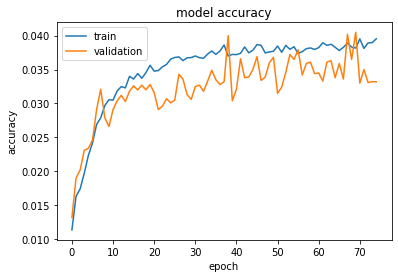

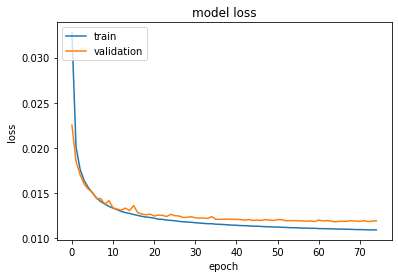

In [0]:
import matplotlib.pyplot as plt
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
def infer_cluster_labels(kmeans, actual_labels):
    inferred_labels = {}
    for i in range(10):
        labels = []
        index = np.where(kmeans.labels_ == i)
        labels.append(actual_labels[index])
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))
        if np.argmax(counts) in inferred_labels:
            inferred_labels[np.argmax(counts)].append(i)
        else:
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  
def infer_data_labels(X_labels, cluster_labels):
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [0]:
encoder = keras.backend.function([autoencoder.layers[0].input],[autoencoder.layers[4].output]) 
encoded_image = encoder([train_x])[0].reshape(-1,10)
km = KMeans(n_clusters=10, init='k-means++',n_init=10, max_iter=300,tol=1e-02, random_state=0)
y_km  = km.fit_predict(encoded_image)
cluster_labels = infer_cluster_labels(km, train_y)
predicted_Y = infer_data_labels(km.labels_, cluster_labels)
from sklearn import metrics
kmeans_acc = metrics.accuracy_score(train_y, predicted_Y)
print(kmeans_acc)

0.5764333333333334


In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
cm=metrics.confusion_matrix(train_y,predicted_Y)
print(cm)

[[4271  374   49 1118   31    0    0   15  135    7]
 [  41 5699    0  109  116    0    0   28    4    3]
 [ 278   23 3008  139 2422    0    0    6  118    6]
 [ 184 3157   36 2524   42    0    0   21   32    4]
 [  37   29 1443 1293 2936    0    0    4  252    6]
 [  13   19   69    0    4    0    0 2744   39 3112]
 [1422  125 2484  874  816    0    0   10  254   15]
 [   0    0    0    0    0    0    0 4676    8 1316]
 [ 140   78    2   41   24    0    0   77 5553   85]
 [   0    5    0    1    0    0    0   55   20 5919]]


**Auto-Encoder based Gaussian Mixture Model**

In [0]:
def infer_cluster_labels_GMM(gmm, actual_labels):
    inferred_labels = {}
    for i in range(10):
        labels = []
        index = np.where(gmm == i)
        labels.append(actual_labels[index])
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))
        if np.argmax(counts) in inferred_labels:
            inferred_labels[np.argmax(counts)].append(i)
        else:
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  

def infer_data_labels_GMM(X_labels, cluster_labels):
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [0]:
from sklearn.mixture import GaussianMixture
op_gmm = GaussianMixture(n_components=10,tol=1e-01,max_iter=300,random_state=0)
output = op_gmm.fit_predict(encoded_image)
gmm_cluster_labels = infer_cluster_labels_GMM(output, train_y)
gmm_predicted_Y = infer_data_labels_GMM(output, gmm_cluster_labels)
gmm_acc = metrics.accuracy_score(train_y, gmm_predicted_Y)

In [0]:
print(gmm_acc)

0.6035833333333334


In [0]:
from sklearn.metrics import confusion_matrix
cm=metrics.confusion_matrix(train_y, gmm_predicted_Y)
print(cm)

[[4699  373  123  607   36    3    0    1  157    1]
 [ 137 5660    8   84  103    0    0    4    4    0]
 [ 168    7 3545  126 2087    0    0    1   66    0]
 [ 493 2820   63 2516   50    1    0    1   56    0]
 [  86   15 1165 1163 3542    0    0    0   29    0]
 [  25    0   25    1   10 2250    0 2449   32 1208]
 [1525  172 2783  535  774    0    0    1  209    1]
 [   1    0    0    0    0 1366    0 4552   21   60]
 [ 144   52   52   28   43   17    0   16 5643    5]
 [   5    0    5    5    4 2114    0   45   14 3808]]
